# Good Demo: Modular DSPy Agent Architecture

## Production-Grade Analytics with Semantic Layer

This notebook demonstrates the **correct** way to build LLM-powered analytics:

### Architecture Principles

1. **Semantic Layer First**: All metrics defined in `config/semantic.yml` with tested SQL
2. **Modular Agents**: Small, focused, testable components with clear contracts
3. **Local-First Logic**: Deterministic rules wherever possible; LLM only for ambiguity
4. **DSPy Signatures**: Structured prompts that are declarative and optimizable
5. **Observability**: Every decision logged with run_id, timings, and provenance

### Business Question

"Which channel mix change is most likely to improve CAC next month, given a recent anomaly in referral traffic?"

### Agent Pipeline

```
Question → Triage → Text-to-Semantic → Metric Compilation → Execution → 
          Hypothesis Simulation → Narration → Observability
```

## 1. Bootstrap: Environment and Database

In [1]:
# Core imports
import sys
import os
from pathlib import Path

# Add utils to path
sys.path.insert(0, str(Path.cwd()))

# Standard libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any, List, Optional

# Our utilities
from utils import (
    load_environment,
    get_db_connection,
    validate_schema,
    SemanticLayer,
    plot_channel_metric,
    RunRecord
)

# DSPy and OpenAI
import dspy
from openai import OpenAI

print("✓ Imports successful")

✓ Imports successful


In [2]:
# Load environment
env_config = load_environment()
print("Environment loaded:")
print(f"  Model: {env_config['OPENAI_MODEL']}")
print(f"  DB Path: {env_config['DB_PATH']}")
print(f"  API Key: {env_config['OPENAI_API_KEY'][:8]}...")

# Configure OpenAI
openai_client = OpenAI(api_key=env_config['OPENAI_API_KEY'])

# Configure DSPy
lm = dspy.LM(f"openai/{env_config['OPENAI_MODEL']}", api_key=env_config['OPENAI_API_KEY'])
dspy.settings.configure(lm=lm)

print("\n✓ LLM configured")

Environment loaded:
  Model: gpt-4o-mini
  DB Path: ../data/synthetic_data.duckdb
  API Key: sk-proj-...

✓ LLM configured


In [3]:
# Connect to database (read-only mode)
db_path = env_config['DB_PATH']
conn = get_db_connection(db_path, read_only=True)
print(f"✓ Connected to database: {db_path}")

# Validate schema
schema_validation = validate_schema(conn)
print(f"\n✓ Schema validation passed")
print(f"  Tables found: {len(schema_validation['tables'])}")
for table in sorted(schema_validation['tables']):
    print(f"    - {table}")

✓ Connected to database: ../data/synthetic_data.duckdb

✓ Schema validation passed
  Tables found: 8
    - dim_adgroups
    - dim_campaigns
    - dim_creatives
    - dim_customers
    - dim_products
    - fact_ad_spend
    - fact_orders
    - fact_sessions


In [4]:
# Set defaults for the session
DEFAULT_WINDOW_DAYS = 90
DEFAULT_LIMIT = 1000

print("Session defaults:")
print(f"  Window: {DEFAULT_WINDOW_DAYS} days")
print(f"  Limit: {DEFAULT_LIMIT} rows")

Session defaults:
  Window: 90 days
  Limit: 1000 rows


## 2. Semantic Catalogue

Load the semantic layer that defines:
- Canonical dimensions (channel, campaign_name, device, region)
- Safe base queries (spend, conversions, revenue by channel)
- Derived metrics (ROAS, CAC by channel)
- Join rules (revenue attribution path)

In [5]:
# Load semantic layer
semantic = SemanticLayer('../config/semantic.yml')
print("✓ Semantic layer loaded")
print(f"  Spec version: {semantic.config.get('version')}")
print(f"  Spec hash: {semantic.spec_hash}")
print(f"\n{semantic.describe_catalogue()}")

✓ Semantic layer loaded
  Spec version: 1.0.0
  Spec hash: 3adeb316e50a

SEMANTIC CATALOGUE

Dimensions:
  • channel: dim_campaigns.channel
    Marketing channel (e.g., search, social, referral, display)
  • campaign_name: dim_campaigns.campaign_name
    Campaign identifier
  • device: fact_sessions.device_type
    Device type (desktop, mobile, tablet)
  • region: dim_customers.region
    Geographic region

Base Queries:
  • spend_by_channel: Total ad spend by channel
  • impressions_clicks_by_channel: Impressions and clicks by channel
  • conversions_by_channel: Conversions by channel (from sessions)
  • revenue_by_channel: Revenue by channel using last-touch attribution (fact_orders -> fact_sessions -> dim_campaigns)

Derived Metrics:
  • roas_by_channel: Return on ad spend by channel (revenue / spend)
  • cac_by_channel: Customer acquisition cost by channel (spend / conversions)

Key Join Rules:
  • revenue_attribution: Revenue must be attributed via last-touch: fact_orders -> fact_

In [6]:
# Show key metric definitions
print("\nCanonical Metric Definitions:")
print("=" * 60)
for metric, formula in semantic.get_metric_definitions().items():
    print(f"  {metric:15} = {formula}")


Canonical Metric Definitions:
  spend           = SUM(fact_ad_spend.spend)
  impressions     = SUM(fact_ad_spend.impressions)
  clicks          = SUM(fact_ad_spend.clicks)
  ctr             = clicks / NULLIF(impressions, 0)
  sessions        = COUNT(*) FROM fact_sessions
  conversions     = SUM(CASE WHEN converted_flag THEN 1 ELSE 0 END)
  cvr             = conversions / NULLIF(sessions, 0)
  orders          = COUNT(DISTINCT fact_orders.order_id)
  revenue         = SUM(fact_orders.revenue)
  roas            = revenue / NULLIF(spend, 0)
  cac             = spend / NULLIF(conversions, 0)


In [7]:
# Show join rules (critical for correctness)
print("\nJoin Rules (Revenue Attribution):")
print("=" * 60)
join_rules = semantic.get_join_rules()
revenue_rule = join_rules.get('revenue_attribution', {})
print(f"Rule: {revenue_rule.get('description')}")
print("Path:")
for step in revenue_rule.get('path', []):
    print(f"  → {step}")
print("\n⚠️ This is enforced in semantic.yml queries; LLM cannot override it")


Join Rules (Revenue Attribution):
Rule: Revenue must be attributed via last-touch: fact_orders -> fact_sessions -> dim_campaigns
Path:
  → fact_orders.session_id = fact_sessions.session_id
  → fact_sessions.campaign_id = dim_campaigns.campaign_id

⚠️ This is enforced in semantic.yml queries; LLM cannot override it


## 3. Agent Architecture with DSPy

Define agents as **DSPy signatures** with clear input/output contracts.

### Agent Roles

1. **TriageAgent**: Classify question type (search vs analysis)
2. **TextToSemanticAgent**: Map natural language to semantic request
3. **MetricRunner**: Compile and execute queries (deterministic)
4. **HypothesisAgent**: Simulate budget scenarios (deterministic)
5. **NarratorAgent**: Generate decision memo with constraints

### Design Principles

- **Local rules first**: Use keywords/templates before LLM
- **Fallback only**: LLM called only when confidence < threshold
- **Validated outputs**: All LLM outputs validated against semantic layer
- **Observable**: Every decision logged with confidence and reasoning

In [8]:
# DSPy Signatures

class TriageSignature(dspy.Signature):
    """Classify a user question as search or analysis."""
    question: str = dspy.InputField(desc="User's business question")
    mode: str = dspy.OutputField(desc="Either 'search' or 'analysis'")
    confidence: float = dspy.OutputField(desc="Confidence score 0-1")
    reason: str = dspy.OutputField(desc="Brief explanation of classification")


class TextToSemanticSignature(dspy.Signature):
    """Map natural language question to semantic request."""
    question: str = dspy.InputField(desc="User's business question")
    available_metrics: str = dspy.InputField(desc="List of available metrics")
    available_dimensions: str = dspy.InputField(desc="List of available dimensions")
    metric: str = dspy.OutputField(desc="Selected metric name")
    dimensions: str = dspy.OutputField(desc="Comma-separated dimension names")
    filters: str = dspy.OutputField(desc="Optional filters as JSON")
    window_days: int = dspy.OutputField(desc="Time window in days")


class HypothesisSignature(dspy.Signature):
    """Analyze channel performance data and propose budget reallocation hypothesis."""
    question: str = dspy.InputField(desc="Original business question")
    cac_data: str = dspy.InputField(desc="CAC by channel as formatted string")
    roas_data: str = dspy.InputField(desc="ROAS by channel as formatted string")
    best_channel: str = dspy.OutputField(desc="Channel with best (lowest) CAC")
    worst_channel: str = dspy.OutputField(desc="Channel with worst (highest) CAC")
    shift_percentage: float = dspy.OutputField(desc="Budget shift percentage (3-10%)")
    reasoning: str = dspy.OutputField(desc="Brief explanation of recommendation")


class NarratorSignature(dspy.Signature):
    """Generate concise decision memo from analysis results."""
    question: str = dspy.InputField(desc="Original business question")
    metrics_used: str = dspy.InputField(desc="Metrics that were queried")
    key_findings: str = dspy.InputField(desc="Key data findings")
    recommendation: str = dspy.InputField(desc="Proposed action with confidence interval")
    memo: str = dspy.OutputField(desc="Decision memo (max 150 words) with risks and next steps")


print("✓ DSPy signatures defined")
print("\n🎯 DSPy Callout: All 5 agents now use declarative DSPy signatures!")
print("  1️⃣ TriageSignature - Classify question type")
print("  2️⃣ TextToSemanticSignature - Map NL to semantic request")
print("  3️⃣ HypothesisSignature - Analyze and propose budget shifts")
print("  4️⃣ NarratorSignature - Generate decision memos")
print("  5️⃣ MetricRunner - Deterministic SQL (no LLM needed)")

✓ DSPy signatures defined

🎯 DSPy Callout: All 5 agents now use declarative DSPy signatures!
  1️⃣ TriageSignature - Classify question type
  2️⃣ TextToSemanticSignature - Map NL to semantic request
  3️⃣ HypothesisSignature - Analyze and propose budget shifts
  4️⃣ NarratorSignature - Generate decision memos
  5️⃣ MetricRunner - Deterministic SQL (no LLM needed)


In [9]:
# Import agent implementations directly from the agents module
from utils.agents import (
    TriageAgent,
    TextToSemanticAgent,
    MetricRunner,
    HypothesisAgent,
    NarratorAgent
)

print("✓ Agent implementations imported from utils.agents")
print("\n" + "=" * 70)
print("🎯 DSPy ARCHITECTURE:")
print("=" * 70)
print("  1️⃣  TriageAgent: Local rules → DSPy fallback")
print("  2️⃣  TextToSemanticAgent: DSPy with semantic layer validation")
print("  3️⃣  MetricRunner: Pure deterministic SQL (no LLM)")
print("  4️⃣  HypothesisAgent: DSPy analysis + bootstrap CI")
print("  5️⃣  NarratorAgent: DSPy narrative with constraints")
print("=" * 70)
print("\n💡 Key Principle: Signatures define WHAT, agents define HOW")
print("   → Signatures (above) = contracts visible to LLM")
print("   → Agents (utils/agents.py) = implementation details")
print("   → This separation makes the system testable and maintainable")

✓ Agent implementations imported from utils.agents

🎯 DSPy ARCHITECTURE:
  1️⃣  TriageAgent: Local rules → DSPy fallback
  2️⃣  TextToSemanticAgent: DSPy with semantic layer validation
  3️⃣  MetricRunner: Pure deterministic SQL (no LLM)
  4️⃣  HypothesisAgent: DSPy analysis + bootstrap CI
  5️⃣  NarratorAgent: DSPy narrative with constraints

💡 Key Principle: Signatures define WHAT, agents define HOW
   → Signatures (above) = contracts visible to LLM
   → Agents (utils/agents.py) = implementation details
   → This separation makes the system testable and maintainable



Now let's run these agents and see these principles in action...

In [10]:
# Initialize agents with their DSPy signatures
triage_agent = TriageAgent(signature=TriageSignature)
text_to_semantic_agent = TextToSemanticAgent(semantic_layer=semantic, signature=TextToSemanticSignature)
metric_runner = MetricRunner(db_conn=conn, semantic_layer=semantic)
hypothesis_agent = HypothesisAgent(signature=HypothesisSignature, n_bootstrap=1000)
narrator_agent = NarratorAgent(signature=NarratorSignature)

print("✓ All agents initialized with DSPy signatures")
print("\n" + "=" * 70)
print("🎯 All 5 agents ready!")
print("=" * 70)
print("\nEach agent combines:")
print("  • DSPy Signature (declarative contract)")
print("  • Implementation logic (validation, fallbacks, observability)")
print("  • This makes them production-ready and testable")

✓ All agents initialized with DSPy signatures

🎯 All 5 agents ready!

Each agent combines:
  • DSPy Signature (declarative contract)
  • Implementation logic (validation, fallbacks, observability)
  • This makes them production-ready and testable


In [11]:
# Initialize observability
run_record = RunRecord(
    model_name=env_config['OPENAI_MODEL'],
    semantic_spec_hash=semantic.spec_hash
)

print(f"✓ Run record initialized: {run_record.run_id}")

✓ Run record initialized: run_20251112_110345_7b4c7f


## 4. Triage: Classify Question Type

🎯 **DSPy in Action**: The TriageAgent uses local keyword rules first (fast path), then falls back to DSPy's TriageSignature for ambiguous questions.

In [12]:
# Business question
business_question = """Which channel mix change is most likely to improve CAC next month, 
given a recent anomaly in referral traffic?"""

# business_question = """What is CAC per channel."""

print(f"Question: {business_question}")
print("\nRunning triage...")

triage_result = triage_agent(business_question)
run_record.record_triage(triage_result)

print("\nTriage Result:")
print("=" * 60)
for key, value in triage_result.items():
    print(f"  {key}: {value}")

assert triage_result['mode'] == 'analysis', "Expected analysis mode for this question"
print("\n✓ Triage complete: mode=analysis")

Question: Which channel mix change is most likely to improve CAC next month, 
given a recent anomaly in referral traffic?

Running triage...

Triage Result:
  mode: analysis
  confidence: 0.9
  reason: Matched 4 analysis keywords
  method: local_rules

✓ Triage complete: mode=analysis


## 5. Semantic Mapping: NL → Structured Request

🎯 **DSPy in Action**: The TextToSemanticAgent uses DSPy to map natural language questions to structured semantic requests, with validation against the semantic layer.

In [13]:
print("Mapping question to semantic request...")

semantic_request = text_to_semantic_agent(business_question)
run_record.record_semantic_request(semantic_request)

print("\nSemantic Request:")
print("=" * 60)
for key, value in semantic_request.items():
    print(f"  {key}: {value}")

print("\n✓ Semantic mapping complete using DSPy")

Mapping question to semantic request...
  → Using DSPy TextToSemanticSignature
     Available metrics: cac_by_channel, conversions_by_channel, impressions_clicks_by_channel, revenue_by_channel, roas_by_channel, spend_by_channel
     Available dimensions: channel, campaign_name, device, region
  ✓ DSPy output validated: cac_by_channel by ['channel', 'campaign_name']

Semantic Request:
  metric: cac_by_channel
  dimensions: ['channel', 'campaign_name']
  filters: {}
  window_days: 30
  method: dspy_constrained

✓ Semantic mapping complete using DSPy


## 6. Metric Compilation and Execution

Compile SQL from semantic layer (no LLM) and execute safely.

In [14]:
# We need both CAC and ROAS by channel for informed decision
metrics_to_run = ['cac_by_channel', 'roas_by_channel']
window_days = semantic_request.get('window_days', DEFAULT_WINDOW_DAYS)

results = {}

for metric in metrics_to_run:
    print(f"\nCompiling and executing: {metric}")
    result = metric_runner(metric, window_days)
    
    # Record in observability
    run_record.record_query(result['query_info'])
    run_record.record_execution(
        result['query_info']['query_id'],
        result['elapsed_ms'],
        result['row_count']
    )
    
    results[metric] = result
    
    print(f"  Query ID: {result['query_info']['query_id']}")
    print(f"  Execution time: {result['elapsed_ms']:.2f} ms")
    print(f"  Rows returned: {result['row_count']}")

print("\n✓ All metrics executed")


Compiling and executing: cac_by_channel
  Query ID: cac_by_channel_30d_057f5fa8
  Execution time: 94.99 ms
  Rows returned: 4

Compiling and executing: roas_by_channel
  Query ID: roas_by_channel_30d_4d6e7c67
  Execution time: 368.69 ms
  Rows returned: 4

✓ All metrics executed



CAC by Channel:
        channel      spend  conversions       cac
       snapchat  230661.41      14925.0 15.454700
           meta  833920.09      42208.0 19.757393
google_shopping  234553.87      11172.0 20.994797
  google_search 1031286.57      37629.0 27.406696


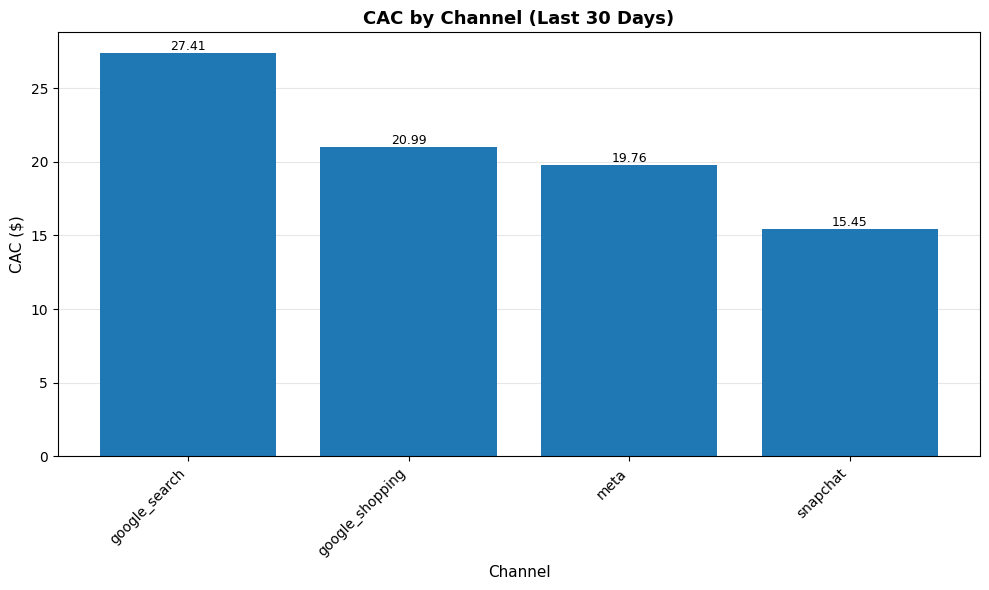

In [15]:
# Display CAC by channel
cac_df = results['cac_by_channel']['df']
print("\nCAC by Channel:")
print("=" * 60)
print(cac_df.to_string(index=False))

# Plot
fig1 = plot_channel_metric(
    cac_df,
    channel_col='channel',
    metric_col='cac',
    title=f'CAC by Channel (Last {window_days} Days)',
    ylabel='CAC ($)'
)
plt.show()

# Save
output_path = Path('./outputs')
output_path.mkdir(exist_ok=True)
fig1.savefig(output_path / f"{run_record.run_id}_cac_by_channel.png", dpi=100, bbox_inches='tight')
run_record.add_artifact('chart', str(output_path / f"{run_record.run_id}_cac_by_channel.png"))


ROAS by Channel:
        channel      spend    revenue     roas
       snapchat  230661.41 1631490.20 7.073096
           meta  833920.09 4634745.70 5.557781
google_shopping  234553.87 1233924.57 5.260730
  google_search 1031286.57 4162749.75 4.036463


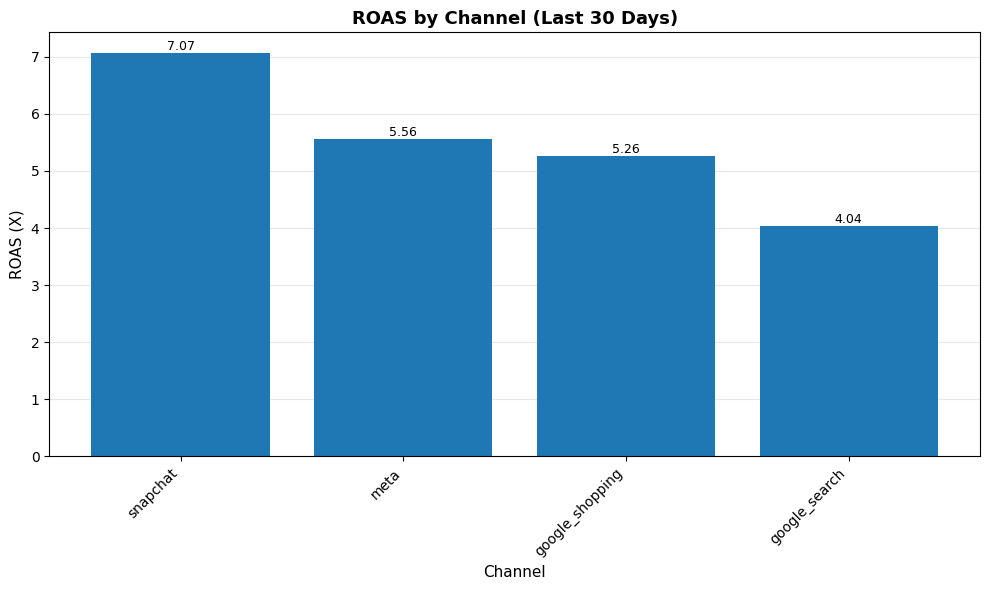

In [16]:
# Display ROAS by channel
roas_df = results['roas_by_channel']['df']
print("\nROAS by Channel:")
print("=" * 60)
print(roas_df.to_string(index=False))

# Plot
fig2 = plot_channel_metric(
    roas_df,
    channel_col='channel',
    metric_col='roas',
    title=f'ROAS by Channel (Last {window_days} Days)',
    ylabel='ROAS (X)'
)
plt.show()

# Save
fig2.savefig(output_path / f"{run_record.run_id}_roas_by_channel.png", dpi=100, bbox_inches='tight')
run_record.add_artifact('chart', str(output_path / f"{run_record.run_id}_roas_by_channel.png"))

## 7. Hypothesis Simulation with DSPy

🎯 **DSPy in Action**: The HypothesisAgent uses DSPy to analyze channel performance data and propose budget shifts, then validates the recommendation with bootstrap confidence intervals.

In [19]:
print("Running hypothesis simulation...\n")

# Pass data to DSPy HypothesisAgent
hypothesis_result = hypothesis_agent(
    cac_df=cac_df,
    roas_df=roas_df,
    question=business_question
)

# Record
hypothesis_params = {
    'shift_percentage': hypothesis_result['shift_percentage'],
    'n_bootstrap': hypothesis_result['n_bootstrap']
}
run_record.record_hypothesis(hypothesis_params, hypothesis_result)

print("\nHypothesis Results:")
print("=" * 60)
print(f"Best channel: {hypothesis_result['best_channel']} (CAC: ${hypothesis_result['best_cac']:.2f})")
print(f"Worst channel: {hypothesis_result['worst_channel']} (CAC: ${hypothesis_result['worst_cac']:.2f})")
print(f"\nDSPy Reasoning: {hypothesis_result.get('dspy_reasoning', 'N/A')}")
print(f"\nCurrent blended CAC: ${hypothesis_result['current_blended_cac']:.2f}")
print(f"Projected blended CAC: ${hypothesis_result['projected_blended_cac']:.2f}")
print(f"Expected delta: ${hypothesis_result['delta_cac']:.2f}")
print(f"\n95% Confidence Interval: [${hypothesis_result['ci_lower']:.2f}, ${hypothesis_result['ci_upper']:.2f}]")
print(f"\nRecommendation: {hypothesis_result['recommendation']}")

print("\n✓ Hypothesis simulation complete")

Running hypothesis simulation...

  → Using DSPy HypothesisSignature to analyze channels
     Analyzing 4 channels...
  ✓ DSPy recommendation: Shift 0.07% from google_search to snapchat
     Reasoning: Snapchat has the lowest CAC at 15.41, making it the most efficient channel for acquiring customers. In contrast, Google Search has the highest CAC at 27.46, indicating it is less efficient. Shifting 7% of the budget from Google Search to Snapchat could improve overall CAC by reallocating funds to a more cost-effective channel.
  ✓ Bootstrap validation complete: 95% CI = [$22.84, $22.90]

Hypothesis Results:
Best channel: snapchat (CAC: $15.41)
Worst channel: google_search (CAC: $27.46)

DSPy Reasoning: Snapchat has the lowest CAC at 15.41, making it the most efficient channel for acquiring customers. In contrast, Google Search has the highest CAC at 27.46, indicating it is less efficient. Shifting 7% of the budget from Google Search to Snapchat could improve overall CAC by reallocating f

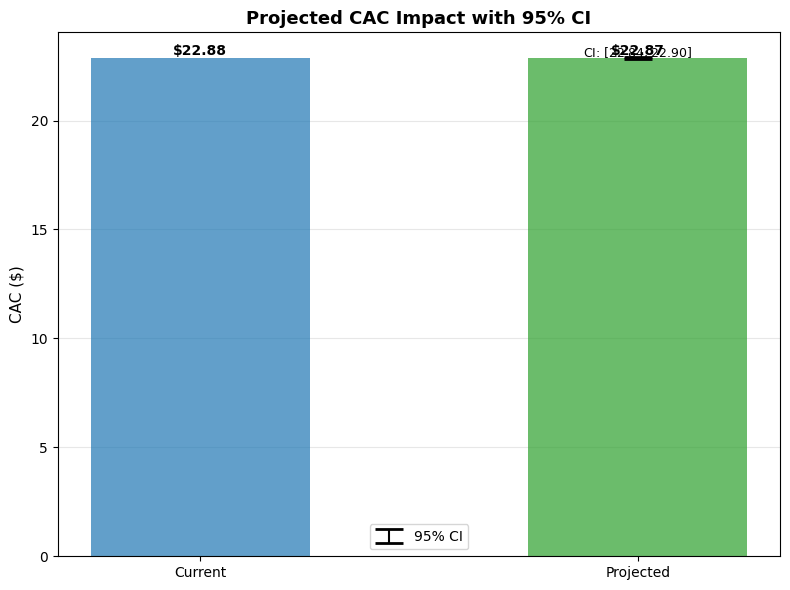

In [20]:
# Plot hypothesis
from utils.plotting import plot_hypothesis_comparison

fig3 = plot_hypothesis_comparison(
    current_cac=hypothesis_result['current_blended_cac'],
    projected_cac=hypothesis_result['projected_blended_cac'],
    ci_lower=hypothesis_result['ci_lower'],
    ci_upper=hypothesis_result['ci_upper'],
    title='Projected CAC Impact with 95% CI'
)
plt.show()

# Save
fig3.savefig(output_path / f"{run_record.run_id}_hypothesis.png", dpi=100, bbox_inches='tight')
run_record.add_artifact('chart', str(output_path / f"{run_record.run_id}_hypothesis.png"))

## 8. Narration: Generate Decision Memo

🎯 **DSPy demo**: The NarratorAgent uses DSPy's NarratorSignature to generate a concise decision memo with constraints.

### What Makes This Production-Grade?

1. **Structured Inputs**: We pass pre-calculated metrics and findings (not raw data)
2. **Constraints**: Word count limit (150 words), must reference metrics
3. **Validation**: Check output meets requirements before accepting
4. **Context-Aware**: LLM gets full business context to generate narrative


In [21]:
# Prepare inputs for narrator
metrics_used = [r['query_info']['query_id'] for r in results.values()]

key_findings = f"""
Analyzed {len(cac_df)} channels over {window_days} days. 
Best CAC: {hypothesis_result['best_channel']} at ${hypothesis_result['best_cac']:.2f}. 
Worst CAC: {hypothesis_result['worst_channel']} at ${hypothesis_result['worst_cac']:.2f}. 
Current blended CAC: ${hypothesis_result['current_blended_cac']:.2f}.
""".strip()

recommendation_text = f"""
Shift {hypothesis_result['shift_percentage']}pp budget from {hypothesis_result['worst_channel']} 
to {hypothesis_result['best_channel']}. 
Projected CAC: ${hypothesis_result['projected_blended_cac']:.2f} 
(95% CI: [${hypothesis_result['ci_lower']:.2f}, ${hypothesis_result['ci_upper']:.2f}]).
""".strip()

print("=" * 70)
print("INPUTS TO NARRATOR AGENT")
print("=" * 70)
print(f"\n📋 Original Question:")
print(f"   {business_question}")
print(f"\n📊 Metrics Used:")
for m in metrics_used:
    print(f"   • {m}")
print(f"\n🔍 Key Findings:")
print(f"   {key_findings}")
print(f"\n💡 Recommendation:")
print(f"   {recommendation_text}")

print("\n" + "=" * 70)
print("Generating decision memo with DSPy...")
print("=" * 70 + "\n")

narration_result = narrator_agent(
    question=business_question,
    metrics_used=metrics_used,
    key_findings=key_findings,
    recommendation=recommendation_text
)

# Record
run_record.record_narration(narration_result['memo'])

print("\n" + "=" * 70)
print("DECISION MEMO (DSPy Output)")
print("=" * 70)
print(narration_result['memo'])
print("\n" + "=" * 70)
print(f"📝 Word count: {narration_result['word_count']} (target: ≤150)")
print(f"✓ Constraints met: {narration_result.get('constraints_met', 'N/A')}")
print(f"✓ Metric references: {len([m for m in metrics_used if m.lower().split('_')[0] in narration_result['memo'].lower()])} found")
print("=" * 70)

print("\n✓ Narration complete")

INPUTS TO NARRATOR AGENT

📋 Original Question:
   Which channel mix change is most likely to improve CAC next month, 
given a recent anomaly in referral traffic?

📊 Metrics Used:
   • cac_by_channel_30d_057f5fa8
   • roas_by_channel_30d_4d6e7c67

🔍 Key Findings:
   Analyzed 4 channels over 30 days. 
Best CAC: snapchat at $15.41. 
Worst CAC: google_search at $27.46. 
Current blended CAC: $22.88.

💡 Recommendation:
   Shift 0.07pp budget from google_search 
to snapchat. 
Projected CAC: $22.87 
(95% CI: [$22.84, $22.90]).

Generating decision memo with DSPy...

  → Using DSPy NarratorSignature to generate decision memo
  ✓ Memo generated: 100 words

DECISION MEMO (DSPy Output)
[Metrics: cac_by_channel_30d_057f5fa8, roas_by_channel_30d_4d6e7c67] To improve our customer acquisition cost (CAC) next month, I recommend reallocating 0.07 percentage points of our budget from Google Search to Snapchat. This shift is projected to slightly lower our blended CAC from $22.88 to $22.87, with a 95% con

## 9. Observability: Complete Run Record



In [22]:
# Finalize run record
run_record.finalize()

print("=" * 80)
print("COMPLETE RUN RECORD")
print("=" * 80)

# Show key sections
record_dict = run_record.to_dict()

print("\n🆔 IDENTIFIERS")
print("-" * 80)
print(f"Run ID: {record_dict['run_id']}")
print(f"Start: {record_dict['start_time']}")
print(f"End: {record_dict['end_time']}")
print(f"Model: {record_dict['environment']['model_name']}")
print(f"Semantic Spec: {record_dict['environment']['semantic_spec_hash']}")

print("\n🧭 TRIAGE DECISION")
print("-" * 80)
triage = record_dict['triage_decision']
print(f"Mode: {triage['mode']}")
print(f"Confidence: {triage['confidence']}")
print(f"Method: {triage['method']}")
print(f"Reason: {triage['reason']}")

print("\n🗣️  SEMANTIC REQUEST")
print("-" * 80)
sem_req = record_dict['semantic_request']
print(f"Primary Metric: {sem_req['metric']}")
print(f"Dimensions: {sem_req['dimensions']}")
print(f"Window: {sem_req['window_days']} days")
print(f"Method: {sem_req['method']}")

print("\n📊 QUERIES EXECUTED")
print("-" * 80)
for query in record_dict['compiled_queries']:
    query_id = query['query_id']
    elapsed = record_dict['execution_timings'].get(query_id, 0)
    rows = record_dict['row_counts'].get(query_id, 0)
    print(f"• {query['metric']:20} → {query_id}")
    print(f"  Timing: {elapsed:>7.2f} ms | Rows: {rows:>4}")

total_time = sum(record_dict['execution_timings'].values())
print(f"\nTotal Query Time: {total_time:.2f} ms")

print("\n🔬 HYPOTHESIS RESULTS")
print("-" * 80)
hyp = record_dict['hypothesis']['result']
print(f"Recommendation: {hyp['recommendation']}")
print(f"Current CAC: ${hyp['current_blended_cac']:.2f}")
print(f"Projected CAC: ${hyp['projected_blended_cac']:.2f}")
print(f"Expected Δ: ${hyp['delta_cac']:.2f}")
print(f"95% CI: [${hyp['ci_lower']:.2f}, ${hyp['ci_upper']:.2f}]")
print(f"Bootstrap samples: {hyp['n_bootstrap']}")

print("\n📄 NARRATION")
print("-" * 80)
narration = record_dict['narration']
print(narration)

print("\n📁 ARTIFACTS")
print("-" * 80)
for artifact in record_dict['artifacts']:
    print(f"• {artifact['type']:10} → {artifact['path']}")

print("\n✅ TESTS")
print("-" * 80)
for test_name, test_result in record_dict['test_results'].items():
    status = "✓ PASS" if test_result['passed'] else "✗ FAIL"
    print(f"{status} | {test_name:30} → {test_result['message']}")

passed = sum(1 for t in record_dict['test_results'].values() if t['passed'])
total = len(record_dict['test_results'])
print(f"\nTests Passed: {passed}/{total}")

print("\n" + "=" * 80)

# Save to file
saved_path = run_record.save(output_dir='./outputs')
print(f"\n💾 Run record saved: {saved_path}")

# Show summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(run_record.summary())

print("\n✓ Observability complete - full audit trail captured!")

COMPLETE RUN RECORD

🆔 IDENTIFIERS
--------------------------------------------------------------------------------
Run ID: run_20251111_224352_9110f3
Start: 2025-11-11T22:43:52.528523
End: 2025-11-11T22:48:39.150915
Model: gpt-4o-mini
Semantic Spec: 3adeb316e50a

🧭 TRIAGE DECISION
--------------------------------------------------------------------------------
Mode: analysis
Confidence: 0.9
Method: local_rules
Reason: Matched 4 analysis keywords

🗣️  SEMANTIC REQUEST
--------------------------------------------------------------------------------
Primary Metric: cac_by_channel
Dimensions: ['channel', 'campaign_name']
Window: 30 days
Method: dspy_constrained

📊 QUERIES EXECUTED
--------------------------------------------------------------------------------
• cac_by_channel       → cac_by_channel_30d_057f5fa8
  Timing:   81.57 ms | Rows:    4
• roas_by_channel      → roas_by_channel_30d_4d6e7c67
  Timing:  378.11 ms | Rows:    4

Total Query Time: 459.68 ms

🔬 HYPOTHESIS RESULTS
------

In [23]:
# Cleanup
conn.close()
print("\n✓ Demo complete. Database connection closed.")
print(f"\n📁 All artifacts saved to: {output_path.absolute()}")
print(f"💾 Run record: {saved_path}")
print(f"\n🎯 Key Takeaway: DSPy signatures + semantic layer + observability = production-ready!")


✓ Demo complete. Database connection closed.

📁 All artifacts saved to: /Users/thomas/Documents/GitHub/tasman-marketing-agent/demo/outputs
💾 Run record: outputs/run_20251111_224352_9110f3.json

🎯 Key Takeaway: DSPy signatures + semantic layer + observability = production-ready!
